In [1]:
% matplotlib inline
import torch
import torch.nn as nn
import numpy as np
from module import Predictor
import pickle
import pandas as pd
import configparser
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.externals import joblib

In [8]:
config_file = 'CH_density_TP_reg.cfg'

In [9]:
cf = configparser.ConfigParser()
cf.read("config/" + config_file)
predictor_dir = cf.get('train', 'predictor_dir')
dataset_dir = cf.get('data','dataset_dir')
dropout = float(cf.get('train', 'dropout'))
inner_layer = eval(cf.get('train', 'inner_layer'))
reg_dir = cf.get('train', 'reg_dir' )
feature_size  =int(cf.get('train', 'feature_size'))
y_label = cf.get('data', 'y_label')
predictor = Predictor(feature_size, inner_layer, dropout)
predictor.load_state_dict(torch.load(predictor_dir))      
test_data = pd.read_csv('data/testset/' + dataset_dir.split('/')[-1])
reg = joblib.load(reg_dir)
X_test = np.array(test_data.loc[:, ('MCI0', 'MCI1', 'vMCI0', 'vMCI1','T(K)','P(bar)', 'C_num')])
y_test = np.array(test_data[y_label])

In [10]:
def stats(X, y, predictor, reg):
    y = torch.Tensor(y)
    y_pred = reg.predict(X)
    y_pred_base = (y_pred > 250) * (y_pred - 250) * 0.4 + y_pred
    predictor.eval()
    MSE_f = nn.MSELoss()
    y_pred_res = predictor(torch.Tensor(X)).view(-1)
    y_pred = torch.Tensor(y_pred_base) + y_pred_res
    MSE = MSE_f(y_pred, y)
    relative_err = abs(y_pred - y) / y
    acc10 = (relative_err < 0.1).sum().item() / len(y)
    acc5 = (relative_err < 0.05).sum().item() / len(y)
    acc2 = (relative_err < 0.02).sum().item() / len(y)
    acc1 = (relative_err < 0.01).sum().item() / len(y)
    MRE = relative_err.sum() / len(y_test)
    
    # print("RMSE_norm:%.3f" % (MSE / y_std / y_std) )
    print("RMSE:%.6f" % (MSE**0.5) )
    print("MRE:%.3f%%" % (MRE*100))
    print("acc1: %d%% acc2: %d%% acc5: %d%% acc10: %d%% " % (acc1*100, acc2*100, acc5*100, acc10*100) )
    result = y_pred.detach().numpy()
    plt.figure(figsize=(7, 7))
    plt.plot([y_test.min(),y_test.max()], [y_test.min(), y_test.max()],color='slategrey')
    # plt.plot([y_test.min(),y_test.max()], [y_test.min() * 0.95, y_test.max() * 0.95], color='orange')
    # plt.plot([y_test.min(),y_test.max()], [y_test.min() * 1.05, y_test.max() * 1.05], color='orange')
    plt.scatter( y_test, result, s=1 )
    plt.ylabel('predict '+ y_label, fontsize=16)
    plt.xlabel('actual ' + y_label, fontsize=16)
    plt.show()  

RMSE:4.245114
MRE:1.510%
acc1: 46% acc2: 73% acc5: 96% acc10: 99% 


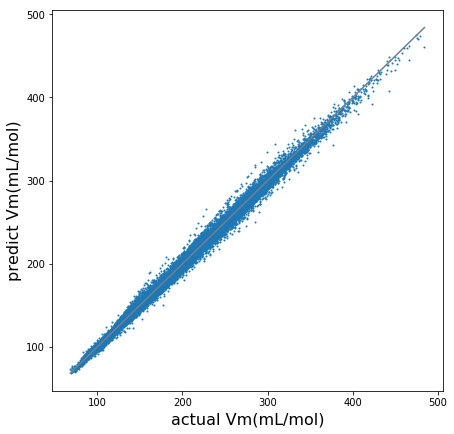

In [11]:
stats(X_test, y_test, predictor, reg)

# analysis of base reg

In [3]:
def reg_transform_predict(X, y, reg):
    ''' transformation network of the linear regressor
    if reg==None train
    else just transform
    '''
    X_base = X[:, :5]
    y_base = reg.predict(X_base)
    y_res = y - y_base
    X_new = np.c_[X_base, X[:,5:], y_base.reshape(-1,1)]
    return X_new, y_res, y_base

In [5]:
cf = configparser.ConfigParser()
cf.read("config/" + config_file)
predictor_dir = cf.get('train', 'predictor_dir')
dataset_dir = cf.get('data','dataset_dir')
dropout = float(cf.get('train', 'dropout'))
inner_layer = eval(cf.get('train', 'inner_layer'))
reg_dir = cf.get('train', 'reg_dir' )
feature_size  =int(cf.get('train', 'feature_size'))
y_label = cf.get('data', 'y_label')
predictor = Predictor(feature_size+1, inner_layer, dropout)
predictor.load_state_dict(torch.load(predictor_dir))      
test_data = pd.read_csv('data/testset/' + dataset_dir.split('/')[-1])
reg = joblib.load(reg_dir)
X_test = np.array(test_data.loc[:, ('MCI0', 'MCI1', 'vMCI0', 'vMCI1', 'C_num','T(K)','P(bar)')])
y_test = np.array(test_data[y_label])

X_test, y_test_res, y_base = reg_transform_predict(X_test, y_test, reg)

In [6]:
def stats_base(X, y, y_base, predictor, reg):
    y = torch.Tensor(y)
    predictor.eval()
    MSE_f = nn.MSELoss()
    y_pred_res = predictor(torch.Tensor(X)).view(-1)
    y_pred = torch.Tensor(y_base) + y_pred_res
    MSE = MSE_f(y_pred, y)
    relative_err = abs(y_pred - y) / y
    acc10 = (relative_err < 0.1).sum().item() / len(y)
    acc5 = (relative_err < 0.05).sum().item() / len(y)
    acc2 = (relative_err < 0.02).sum().item() / len(y)
    acc1 = (relative_err < 0.01).sum().item() / len(y)
    MRE = relative_err.sum() / len(y_test)
    
    # print("RMSE_norm:%.3f" % (MSE / y_std / y_std) )
    print("RMSE:%.6f" % (MSE**0.5) )
    print("MRE:%.3f%%" % (MRE*100))
    print("acc1: %d%% acc2: %d%% acc5: %d%% acc10: %d%% " % (acc1*100, acc2*100, acc5*100, acc10*100) )
    result = y_pred.detach().numpy()
    plt.figure(figsize=(7, 7))
    plt.plot([y_test.min(),y_test.max()], [y_test.min(), y_test.max()],color='slategrey')
    # plt.plot([y_test.min(),y_test.max()], [y_test.min() * 0.95, y_test.max() * 0.95], color='orange')
    # plt.plot([y_test.min(),y_test.max()], [y_test.min() * 1.05, y_test.max() * 1.05], color='orange')
    plt.scatter( y_test, result, s=1 )
    plt.ylabel('predict '+ y_label, fontsize=16)
    plt.xlabel('actual ' + y_label, fontsize=16)
    plt.show()  

RMSE:4.599095
MRE:1.625%
acc1: 44% acc2: 71% acc5: 95% acc10: 99% 


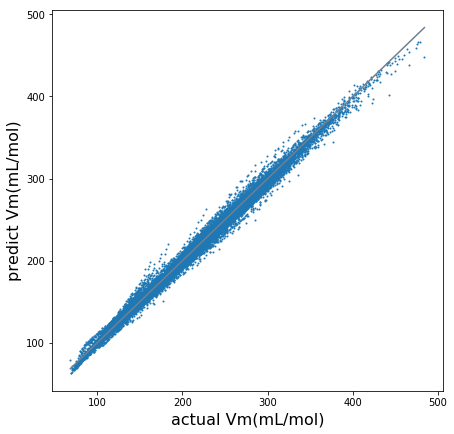

In [7]:
stats_base(X_test, y_test, y_base, predictor, reg)